# Stage 3 - HackBio Internship: Neuroscience and Psychology
## Team Members:
**Chama BENSLIMANE (Leader)**: [GitHub Profile](https://github.com/BenslimaneChama)

**Mohammad HICHAM POLO**: [GitHub Profile](https://github.com/MohammadHichamPolo)


## Project Overview
Here's the approach we followed for this project : 

- Data preprocessing and exploration
- Application of machine learning models for classification
- Biostatistical analysis of relevant factors
- Interpretation of results through markdown explanations and visualizations

Our work consists of 3 parts:
- Data processing 
- training machine, female data with different models 
- training machine, male data with different models 

**In this notebook, we focused on the male dataframe, and performed machine learning with three models: Logistic Regression, Random Forest, and XGBoost, where we tried to select the best features that would let us predict depression.**


*All findings, including statistical interpretations and graph analyses, are documented within this notebook to provide a comprehensive understanding of the methodology and outcomes.*

# Packages Needed

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import LabelEncoder
from joblib import Parallel, delayed
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score,roc_curve,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# DATA IMPORTINT AND TREATEMENT

*For further details, please check the first notebook on data processing, treatement and cleaning available on Github.*

In [231]:
df = pd.read_csv('http://raw.githubusercontent.com/HackBio-Internship/2025_project_collection/refs/heads/main/Python/Dataset/Student%20Depression%20Dataset.csv')
df=df.dropna()
df = df.drop(columns=['id'])
df = df[(df['Job Satisfaction'] == 0.0) & (df['Work Pressure'] == 0.0)]
df = df[df['Profession'] == 'Student']
df = df.drop(columns=['Profession'])
df = df.drop(columns=['Job Satisfaction'])
df = df.drop(columns=['Work Pressure'])
valid_cities = [
    'Visakhapatnam', 'Bangalore', 'Srinagar', 'Varanasi', 'Jaipur', 'Pune', 'Thane',
    'Chennai', 'Nagpur', 'Nashik', 'Vadodara', 'Kalyan', 'Rajkot', 'Ahmedabad',
    'Kolkata', 'Mumbai', 'Lucknow', 'Indore', 'Surat', 'Ludhiana', 'Bhopal',
    'Meerut', 'Agra', 'Ghaziabad', 'Hyderabad', 'Vasai-Virar', 'Kanpur', 'Patna',
    'Faridabad', 'Delhi'
]


df = df[df['City'].isin(valid_cities)]

In [232]:
le_city = LabelEncoder()
df['City'] = le_city.fit_transform(df['City'])

# Save the mapping of City names to numbers
city_mapping = dict(zip(le_city.classes_, le_city.transform(le_city.classes_)))
categorical_cols = ['Gender', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

# Create a dictionary to store mappings
label_encoders = {}

# Encode each categorical column
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    
    # Store the mapping of labels to numbers
    label_encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

sleep_mapping = {
    'Less than 5 hours': 4,
    '5-6 hours': 5.5,
    'Others': 6.5,
    '7-8 hours': 7.5,
    'More than 8 hours': 9
}

df['Sleep Duration'] = df['Sleep Duration'].map(sleep_mapping)

In [233]:
df = df[df['Age'] <= 40]
df = df[df['CGPA'] > 0]

# POTENTIAL PREDICTIVE FEATURES INVISTIGATION USING PCA AND RFE ALONGSIDE A BENCHMARK OF MODEL TRAINING FOR FEMALE

## DATA PREPARATION FOR MACHINE LEARNING


#### CREATING A FUNCTION TO INCLUDE ONLY MALES

In [234]:
df_male = df[df["Gender"] == 1]
df_male = df_male.drop(columns=['Gender'])

### Feature Selection and Evaluation of Classification Models for the Prediction of Depression

In [6]:

X = df_male.drop(columns=['Depression'])
Y = df_male["Depression"]

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

def train_rfe_model(model_name, model, num_features, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    accuracy_scores = []
    auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    mean_fpr = np.linspace(0, 1, 100)  # Standard scale for ROC curves
    tpr_list = []  
    selected_features = None 
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        
        rfe = RFE(model, n_features_to_select=num_features)
        X_train_selected = rfe.fit_transform(X_train, y_train)
        X_test_selected = rfe.transform(X_test)
        
        
        if selected_features is None:
            selected_features = X_train.columns[rfe.support_].tolist()
        
        
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

       
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        auc = roc_auc_score(y_test, y_pred_proba)
        auc_scores.append(auc)
        report = classification_report(y_test, y_pred, output_dict=True)
        precision_scores.append(report['weighted avg']['precision'])
        recall_scores.append(report['weighted avg']['recall'])
        f1_scores.append(report['weighted avg']['f1-score'])
        
       
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        tpr_list.append(np.interp(mean_fpr, fpr, tpr))  

   
    return {
        "Model": model_name,
        "Num_Features": num_features,
        "Selected_Features": ", ".join(selected_features),  
        "Accuracy": np.mean(accuracy_scores),
        "AUC": np.mean(auc_scores),
        "Precision": np.mean(precision_scores),
        "Recall": np.mean(recall_scores),
        "F1-Score": np.mean(f1_scores),
        "mean_fpr": np.array(mean_fpr),
        "mean_tpr": np.mean(tpr_list, axis=0),
    }


tasks = [(model_name, model, num_features, X, Y) for model_name, model in models.items() for num_features in range(1, 13)]

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_rfe_model)(*task) for task in tasks
)


df_results = pd.DataFrame(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  36 | elapsed:   15.1s remaining:   45.5s
[Parallel(n_jobs=-1)]: Done  13 out of  36 | elapsed:   37.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  17 out of  36 | elapsed:   52.8s remaining:   59.1s
[Parallel(n_jobs=-1)]: Done  21 out of  36 | elapsed:   56.3s remaining:   40.2s
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:  1.1min remaining:   28.0s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  1.7min remaining:   25.1s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  2.3min remaining:   12.4s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.4min finished


We selected the best features to predict depression using Recursive Feature Elimination (RFE) so that we tested a combination of 1 to X features (here X = 12), then trained several machine learning models: 
**Logistic regression**: Simple, interpretable model for binary classification.
**Random Forest**: Ensemble algorithm based on several decision trees.
**XGBoost**: Powerful ensemble algorithm using boosting.

Models were evaluated using several metrics:
- Accuracy: rate of correct predictions, 
- Are Under Curve ROC (AUC): Area under the ROC curve, which measures the model's ability to classify positive and negative cases,
- Recall, F1-Score, which give more detailed indications of prediction quality.

As a result, we had obtained 36 combinations that were tested in parallel, enabling us to run them quickly in *3.7min* (instead of several hours if we ran each one individually), and then we could check in df_results to really see which model got the best score.

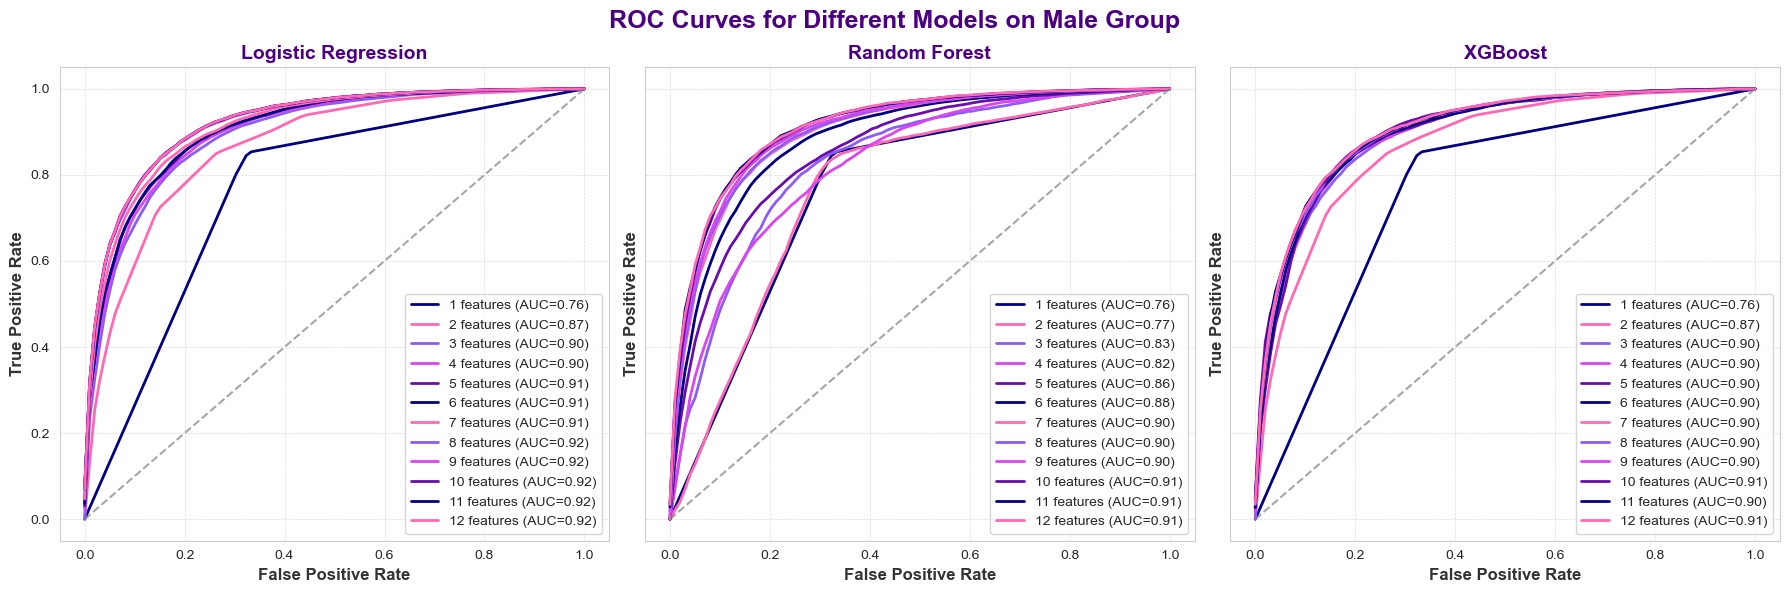

In [7]:

sns.set_style("whitegrid")

custom_palette = ["#6a0dad", "#000080", "#ff69b4", "#8b5cf6", "#d946ef"]


fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)


fig.suptitle("ROC Curves for Different Models on Male Group", fontsize=18, fontweight='bold', color="#4B0082")

for ax, (model_name, model) in zip(axes, models.items()):
    for num_features in range(1, 14):
        subset = df_results[(df_results["Model"] == model_name) & (df_results["Num_Features"] == num_features)]
        if not subset.empty:
            ax.plot(
                subset["mean_fpr"].values[0], subset["mean_tpr"].values[0], 
                label=f"{num_features} features (AUC={subset['AUC'].values[0]:.2f})",
                color=custom_palette[num_features % len(custom_palette)], linewidth=2
            )

    # Reference line (gray dashed)
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", alpha=0.7)

   
    ax.set_xlabel("False Positive Rate", fontsize=12, fontweight='bold', color="#333333")
    ax.set_ylabel("True Positive Rate", fontsize=12, fontweight='bold', color="#333333")

    ax.set_title(f"{model_name}", fontsize=14, fontweight='bold', color="#4B0082")

    
    ax.legend(fontsize=10, frameon=True, loc="lower right")

    
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)


plt.tight_layout(rect=[0, 0, 1, 1.01])  # Leaves space for the common title
plt.show()

We generated ROC curves for each of the three models we tested, applied to the female group, testing different selections of characteristics.
For each of the three models, the AUC varies from 0.77 to 0.92, but what changes is rather the number of features, and how long it took to reach 0.92 approximately.

- For **Logistic Regression**, with 3 features alone, we've already reached 0.90, and with *8 features*, we've reached the maximum value *(0.92)*.
- For **Random Forest**, it took 7 features to reach 0.90, and even then it never reached the maximum value (0.92).
- Like Logistic Regression, **XGBoost** was able to reach 0.90 with just 3 features, but was never able to reach 0.91 or 0.92.

Our aim is to select the best model capable of predicting depression with the fewest features possible, **so for now, based on AUC, the best: Logistic Regression.**


In [8]:
df_results.to_csv('Male_ML_Benchmark_Results.csv', index=False)
df_results

,Model,Num_Features,Selected_Features,Accuracy,AUC,Precision,Recall,F1-Score,mean_fpr,mean_tpr
0,Logistic Regression,1,Have you ever had suicidal thoughts ?,0.779585,0.764668,0.778391,0.779585,0.777252,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.0, 0.026740123081760513, 0.0534802461635210..."
1,Logistic Regression,2,"Academic Pressure, Have you ever had suicidal ...",0.803524,0.867349,0.802613,0.803524,0.802660,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.0, 0.13295849651197303, 0.25465645259999903..."
2,Logistic Regression,3,"Academic Pressure, Have you ever had suicidal ...",0.824300,0.895958,0.823602,0.824300,0.823301,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.0, 0.2361971657238581, 0.32590716513432944,..."
3,Logistic Regression,4,"Academic Pressure, Dietary Habits, Have you ev...",0.829462,0.902239,0.828847,0.829462,0.828806,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.02410566868464502, 0.25727070744131836, 0.3..."
4,Logistic Regression,5,"Academic Pressure, Study Satisfaction, Dietary...",0.833592,0.906902,0.832989,0.833592,0.832822,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.03082003302146395, 0.2854005103317156, 0.37..."
5,Logistic Regression,6,"Academic Pressure, Study Satisfaction, Dietary...",0.835141,0.907313,0.834559,0.835141,0.834223,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.03632361034672537, 0.2843859619864023, 0.37..."
6,Logistic Regression,7,"Academic Pressure, Study Satisfaction, Dietary...",0.838496,0.913134,0.837926,0.838496,0.837733,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.047220693450742986, 0.28442042883429786, 0...."
7,Logistic Regression,8,"Age, Academic Pressure, Study Satisfaction, Di...",0.848175,0.920937,0.847719,0.848175,0.847524,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.067473858007705, 0.3079801871216291, 0.4354..."
8,Logistic Regression,9,"Age, Academic Pressure, Study Satisfaction, Sl...",0.848110,0.921959,0.847636,0.848110,0.847473,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.071326362135388, 0.3160154100165108, 0.4458..."
9,Logistic Regression,10,"Age, Academic Pressure, CGPA, Study Satisfacti...",0.848433,0.922044,0.847962,0.848433,0.847794,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.071326362135388, 0.3184369840396257, 0.4449..."


This time, based not only on AUC, but also Accuracy, Precision, Recall and F1-Score, we note that :
- The maximum number of features for Logistic Regression that allows us to have the maximum score = 8 features, with Accuracy = 84.38%, AUC = 92%, Precision =84.3%, and F1-Score = 84%.
- For Random Forest = 12 features, with Accuracy = 84%, AUC = 91%, Precision = 84%, F1-Score = 84%.
- For XG-Boost = 3 features, with Accuracy = 83%, AUC = 90%, Precision = 83%, F1-Score = 83%

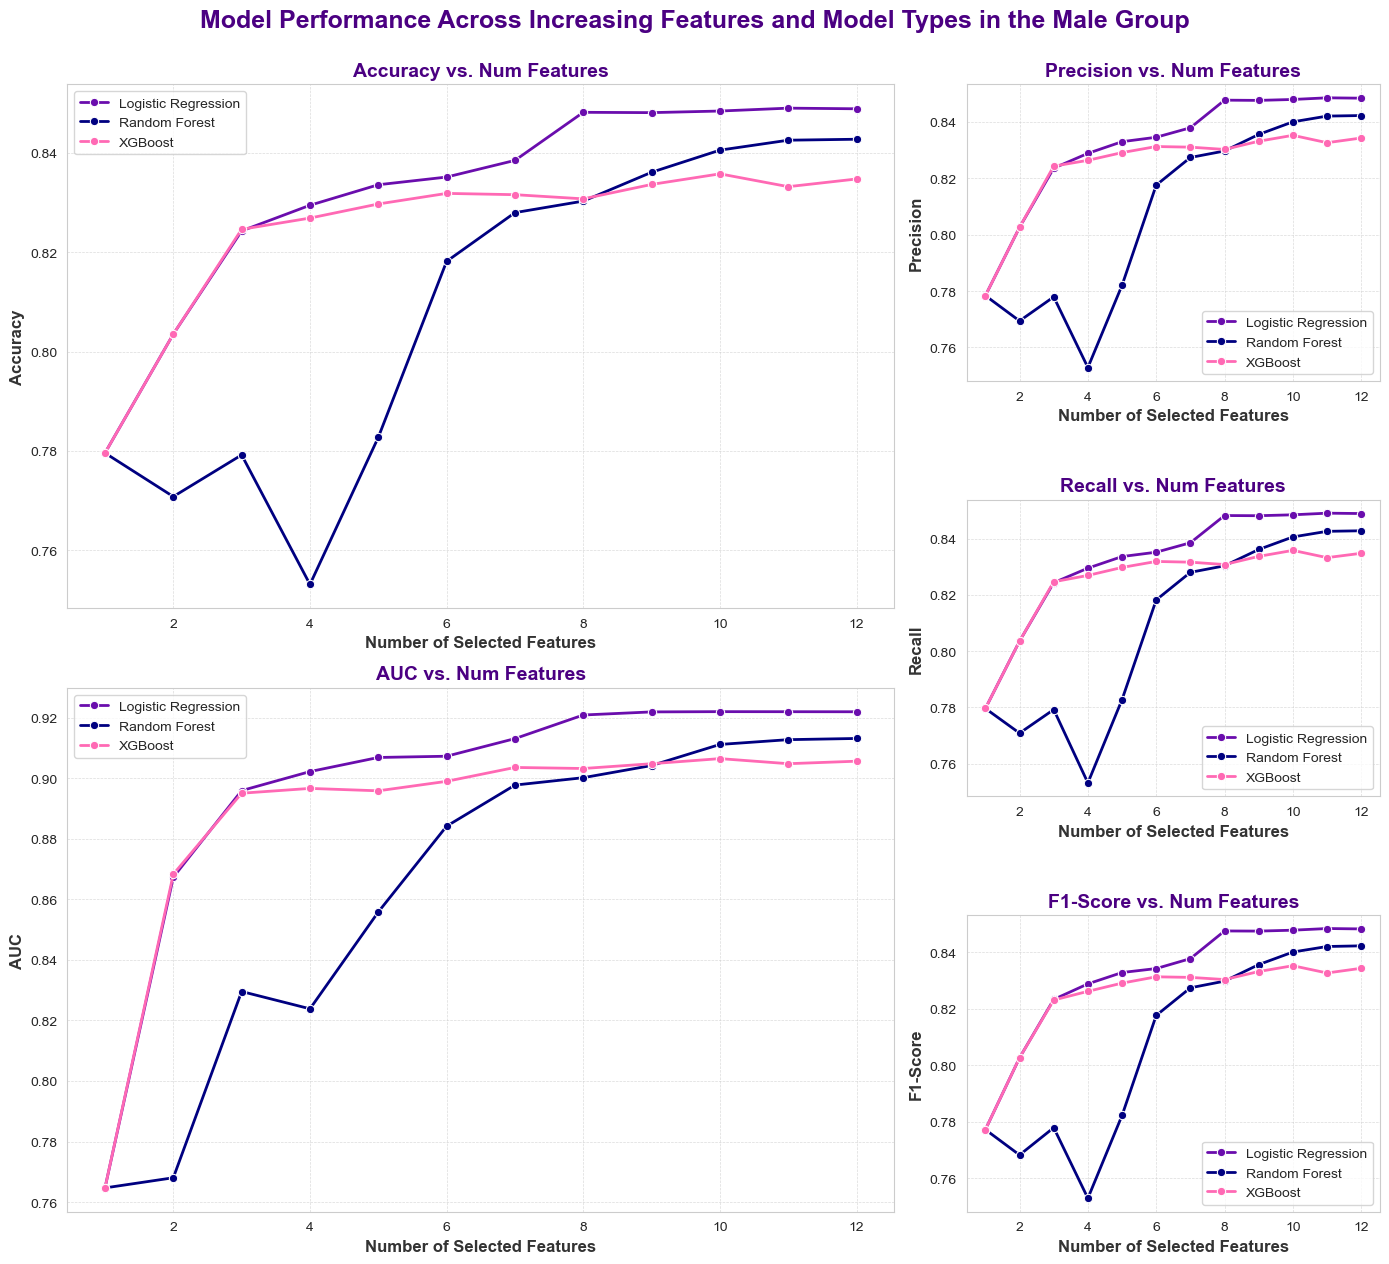

The best model by Accuracy is a Logistic Regression model with 0.8490134590762889 requiring 11 selected features.
The best model by AUC is a Logistic Regression model with 0.9220437950908364 requiring 10 selected features.
The best model by Precision is a Logistic Regression model with 0.8485467710095443 requiring 11 selected features.
The best model by Recall is a Logistic Regression model with 0.8490134590762889 requiring 11 selected features.
The best model by F1-Score is a Logistic Regression model with 0.8483827387773093 requiring 11 selected features.


In [9]:
# Define the metrics
metrics = ["Accuracy", "AUC", "Precision", "Recall", "F1-Score"]
titles = ["Accuracy vs. Num Features", "AUC vs. Num Features", 
          "Precision vs. Num Features", "Recall vs. Num Features", "F1-Score vs. Num Features"]


sns.set_style("whitegrid")


custom_palette = ["#6a0dad", "#000080", "#ff69b4", "#8b5cf6", "#d946ef"]


fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])  


fig.suptitle(
    "Model Performance Across Increasing Features and Model Types in the Male Group",
    fontsize=18, fontweight='bold', color="#4B0082", y=1.05  # Dark purple
)


ax1 = fig.add_subplot(gs[0, 0])  
ax2 = fig.add_subplot(gs[1, 0])  

# Create a grid inside the right-side column to stack the three small plots
gs_right = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[:, 1], hspace=0.4)
ax3 = fig.add_subplot(gs_right[0, 0])  
ax4 = fig.add_subplot(gs_right[1, 0])  
ax5 = fig.add_subplot(gs_right[2, 0])  

axes = [ax1, ax2, ax3, ax4, ax5]


for i, metric in enumerate(metrics):
    ax = axes[i]
    
   
    for idx, model in enumerate(df_results["Model"].unique()):
        subset = df_results[df_results["Model"] == model]
        sns.lineplot(
            data=subset, x="Num_Features", y=metric, ax=ax, label=model, marker='o',
            color=custom_palette[idx % len(custom_palette)], linewidth=2
        )

 
    ax.set_title(titles[i], fontsize=14, fontweight='bold', color="#4B0082")  # Dark purple

   
    ax.set_xlabel("Number of Selected Features", fontsize=12, fontweight='bold', color="#333333")
    ax.set_ylabel(metric, fontsize=12, fontweight='bold', color="#333333")

  
    ax.legend(fontsize=10, frameon=True, loc="best")

    
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)


plt.tight_layout(rect=[0, 0, 1, 1.05])  
plt.show()

for metric in metrics: 
    df_sorted = df_results.sort_values(by=metric, ascending=False)
    model, number,value = df_sorted.iloc[0][["Model", "Num_Features",metric]]
    print(f"The best model by {metric} is a {model} model with {value} requiring {number} selected features.")

From this graph, we can better visualize how Logistic regression outperforms the two remaining models since the 4th selected feature.

In [10]:

def add_model_scores(df):
    
    metrics = ["Accuracy", "AUC", "Precision", "Recall", "F1-Score"]
    for metric in metrics:
        df[f"Norm_{metric}"] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())

   
    df["Performance_Score"] = (
        0.2 * df["Norm_Accuracy"] +
        0.15 * df["Norm_AUC"] +
        0.15 * df["Norm_Precision"] +
        0.2 * df["Norm_Recall"] +
        0.3 * df["Norm_F1-Score"]
    )

   
    max_features = df["Num_Features"].max()
    df["Feature_Penalty"] = df["Num_Features"] / max_features * 0.05 

   
    df["Final_Score"] = df["Performance_Score"] - df["Feature_Penalty"]
    
    return df



df_results = add_model_scores(df_results)

In [11]:
best_models = df_results.loc[df_results.groupby("Model")["Final_Score"].idxmax()]
best_models = best_models.sort_values(by="Final_Score", ascending=False)
best_models

,Model,Num_Features,Selected_Features,Accuracy,AUC,Precision,Recall,F1-Score,mean_fpr,mean_tpr,Norm_Accuracy,Norm_AUC,Norm_Precision,Norm_Recall,Norm_F1-Score,Performance_Score,Feature_Penalty,Final_Score
7,Logistic Regression,8,"Age, Academic Pressure, Study Satisfaction, Di...",0.848175,0.920937,0.847719,0.848175,0.847524,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.067473858007705, 0.3079801871216291, 0.4354...",0.991252,0.992966,0.991347,0.991252,0.990997,0.991447,0.033333,0.958114
22,Random Forest,11,"Age, City, Academic Pressure, CGPA, Study Sati...",0.842561,0.912789,0.842066,0.842561,0.842022,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.02839845899834893, 0.26502178267725873, 0.3...",0.932703,0.941193,0.932251,0.932703,0.933328,0.934096,0.045833,0.888263
33,XGBoost,10,"Age, Academic Pressure, CGPA, Study Satisfacti...",0.835786,0.906522,0.835247,0.835786,0.835225,"[0.0, 0.010101010101010102, 0.0202020202020202...","[0.04821133736929004, 0.2756191524490919, 0.41...",0.862048,0.901372,0.860972,0.862048,0.862087,0.867797,0.041667,0.826130


We calculated a final score for each model by normalizing their performance (Accuracy, AUC, Precision, Recall, F1-Score) and applying a penalty according to the number of features used.
### **1. Normalization of Metrics**  
$$
\text{Norm\_Metric} = \frac{\text{Metric} - \min(\text{Metric})}{\max(\text{Metric}) - \min(\text{Metric})}
$$

### **2. Performance Score Calculation**  
$$
\text{Performance\_Score} = 0.2 \times \text{Norm\_Accuracy} + 0.15 \times \text{Norm\_AUC} + 0.15 \times \text{Norm\_Precision} + 0.2 \times \text{Norm\_Recall} + 0.3 \times \text{Norm\_F1-Score}
$$

### **3. Final Score Calculation (with Feature Penalty)**  
$$
\text{Final\_Score} = \text{Performance\_Score} - \left( \frac{\text{Num\_Features}}{\max(\text{Num\_Features})} \times 0.05 \right)
$$


When no penalty is applied, the Logistic Regression model with 11 features is considered the best, achieving a score of 0.999877.


However, once a penalty based on the number of features used is applied, the score is adjusted by arbitrarily subtracting 0.05 for every unit of the ratio between the number of selected features and the total possible features.

The best models are ranked according to this final score:

1st : Logistic Regression (Final Score = 0.958302)

- With Optimal number of features = 8
- Advantages: Excellent overall performance, good interpretability
- Disadvantages: Slightly penalized for its number of features

2nd: Random Forest (Final Score = 0.886230)
- Optimal number of features: 11
- Advantages: Good robustness and ability to capture complex relationships
- Disadvantages: Highly penalized by the use of 12 features

3rd: XGBoost (Final Score = 0.829091)
- Optimal number of features: 10
- Advantages: Very efficient with few features (less penalized)
- Disadvantages: Less efficient than Logistic Regression and Random Forest in terms of AUC and Accuracy.

Final choice: Logistic Regression for robustness and interpretability, XGBoost for a simple model with few variables.

In [12]:
best_models.iloc[0]["Selected_Features"]

'Age, Academic Pressure, Study Satisfaction, Dietary Habits, Have you ever had suicidal thoughts ?, Work/Study Hours, Financial Stress, Family History of Mental Illness'

In [13]:
single_feature_row = df_results[df_results["Num_Features"] == 1]
single_feature_row["Selected_Features"].unique()

array(['Have you ever had suicidal thoughts ?'], dtype=object)

In [235]:

X = df_male.drop(columns=["Depression"])
y = df_male["Depression"]


# Feature Selection with RFE (Selects 8 Best Features)
logreg = LogisticRegression(max_iter=1000)
rfe = RFE(logreg, n_features_to_select=8)
X_rfe = rfe.fit_transform(X, y)


X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)


model = LogisticRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)


print(f"Model Accuracy: {accuracy * 100:.2f}%")

report = classification_report(y_test, y_pred)


print("\nClassification Report:")
print(report)

Model Accuracy: 83.84%

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1266
           1       0.85      0.88      0.87      1834

    accuracy                           0.84      3100
   macro avg       0.83      0.83      0.83      3100
weighted avg       0.84      0.84      0.84      3100



We then calculated the accuracy of these selected models and obtained = 83.11%.

Which is a very good percentage 

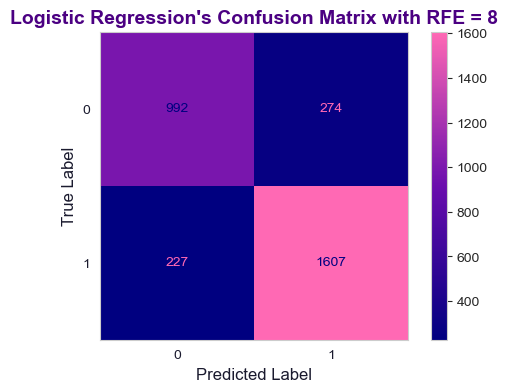

In [236]:

text_color = "#1a1a2e"  
highlight_color = "#6a5acd"  


cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 4)) 



custom_cmap = LinearSegmentedColormap.from_list("chroma", ["#000080", "#6a0dad", "#ff69b4"])  

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=custom_cmap, ax=ax, colorbar=True) 
ax.grid(False)  


plt.title("Logistic Regression's Confusion Matrix with RFE = 8", fontsize=14, fontweight="bold", color="#4B0082")
plt.xlabel("Predicted Label", fontsize=12, color=text_color)
plt.ylabel("True Label", fontsize=12, color=text_color)
plt.xticks(color=text_color)
plt.yticks(color=text_color)


plt.show()

# Selected Features analysis
This SHAP summary plot represents the impact of various features on a machine learning model's predictions for depression in the female group. The SHAP (SHapley Additive exPlanations) values indicate how much each feature contributes to either increasing or decreasing the likelihood of depression. The x-axis represents the SHAP values, where negative values suggest a lower probability of depression, while positive values indicate a higher probability. The y-axis lists the features, ranked by their importance in the model’s predictions.
The color gradient, from dark blue to pink, helps us see whether higher or lower values of each factor increase or decrease the likelihood of depression.

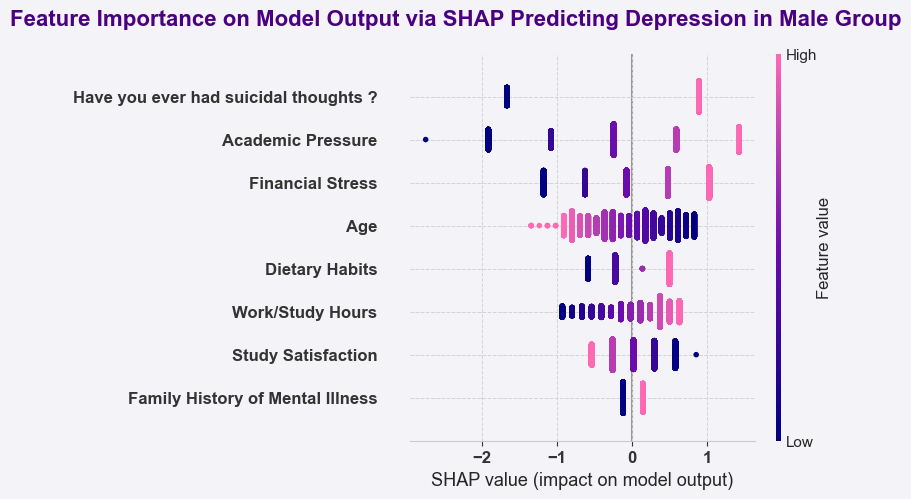

In [237]:



sns.set_style("whitegrid")


background_color = "#f4f4f8" 
title_color = "#4B0082"  


selected_features = X.columns[rfe.get_support()]


explainer = shap.Explainer(model, X_rfe)
shap_values = explainer(X_rfe)


custom_colors = ["#000080", "#6a0dad", "#ff69b4"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

from matplotlib.colors import LinearSegmentedColormap
import shap

plt.figure(figsize=(12, 6), facecolor=background_color)

shap.summary_plot(shap_values, X_rfe, feature_names=selected_features, cmap=custom_cmap, show=False)

plt.suptitle(
    "Feature Importance on Model Output via SHAP Predicting Depression in Male Group",
    fontsize=16, fontweight="bold", color=title_color, 
    x=0.5, ha="center", y=1.05
)
plt.xticks(fontsize=12, fontweight='bold', color="#333333")
plt.yticks(fontsize=12, fontweight='bold', color="#333333")
plt.gca().set_facecolor(background_color)
plt.grid(color="lightgray", linestyle="--", linewidth=0.7)

plt.show()

### **Male Students:**
- **Suicidal Thoughts:**  
  *What do you think?* Suicidal thoughts are the strongest predictor of depression in both male and female students. When RFE = 1, they contribute (0.779585 + 0.779585 + 0.779585) / 3 to the model performance for male students. How do you feel about the role of suicidal ideation in mental health?  
  **Key Insight:** Suicidal thoughts are a major indicator of depression.

- **Academic Pressure:**  
  *Do you feel stressed by your studies?* For males, academic pressure has less of an impact on depression than for females. Do you think males handle academic stress differently?  
  **Key Insight:** Academic pressure affects males differently, and some may cope better than others.

- **Financial Stress:**  
  *Is financial pressure a concern for you?* For males, financial stress plays a slightly stronger role in depression. Do you think financial stability is a bigger issue for males?  
  **Key Insight:** Financial concerns weigh heavier on males, possibly due to societal expectations.

- **Age:**  
  *How does your age impact your mental health?* Age plays a more significant role in depression risk for males, with depression potentially shifting as they move through life stages. Do you think age influences mental health in a similar way for you?  
  **Key Insight:** Age is more influential for males, with depression risks changing over time.

- **Work or Study Hours:**  
  *How many hours do you work or study?* Work and study hours show more variability for males than females, suggesting that individual circumstances affect depression risk. How do work/study hours affect your mental health?  
  **Key Insight:** The effect of work hours varies depending on personal circumstances.

- **Sleep Duration:**  
  *How much sleep do you get?* Interestingly, sleep duration doesn’t show a clear link to depression in males. Do you think sleep quality affects your mental health?  
  **Key Insight:** Sleep doesn’t have as strong of an effect on male depression, suggesting possible differences in awareness or impact.

- **Family History of Mental Illness:**  
  *Does your family history affect your mental health?* Family history of mental illness is a minor contributor to depression in males, much like females. How much do you think family history matters in depression?  
  **Key Insight:** Family history plays a role but isn’t a strong predictor.

- **CGPA (Grade Point Average):**  
  *Do grades stress you out?* Like females, CGPA has a minimal impact on depression for males. How important do you think grades are in determining your mental well-being?  
  **Key Insight:** Academic performance is not as crucial as other stress-related factors for males.